In [ ]:
# Bike Share Toronto — Data Preparation (2024)

This notebook loads raw Bike Share trip data and daily weather data,
cleans and aggregates the data to a daily level, and prepares a dataset
for analysis and forecasting.


In [3]:
import os
import pandas as pd
from pathlib import Path



In [4]:
BIKE_FOLDER = "/kaggle/input/bikeshare-weather/bikeshare-ridership-2024"

files = sorted([f for f in os.listdir(BIKE_FOLDER) if f.endswith(".csv")])

dfs = []
for fname in files:
    df = pd.read_csv(f"{BIKE_FOLDER}/{fname}", encoding="cp1252")
    dfs.append(df)

bike = pd.concat(dfs, ignore_index=True)
bike.head()



,ï»¿Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,Trip Id,Model
0,26682740.0,528,7041,01/01/2024 00:00,Edward St / Yonge St,7130.0,01/01/2024 00:08,Davenport Rd / Bedford Rd,7855,Casual Member,NaN,NaN
1,26682742.0,1924,7245,01/01/2024 00:02,Tecumseth St / Queen St W - SMART,7259.0,01/01/2024 00:34,Lower Spadina Ave / Lake Shore Blvd,2453,Casual Member,NaN,NaN
2,26682743.0,2741,7052,01/01/2024 00:03,Wellington St W / Bay St,7366.0,01/01/2024 00:49,Fort York Blvd / Bathurst St SMART,7332,Casual Member,NaN,NaN
3,26682744.0,353,7041,01/01/2024 00:03,Edward St / Yonge St,7418.0,01/01/2024 00:09,College Park - Yonge St Entrance,782,Casual Member,NaN,NaN
4,26682746.0,2118,7721,01/01/2024 00:04,NaN,7721.0,01/01/2024 00:40,NaN,1008,Casual Member,NaN,NaN


In [5]:
bike["start_time"] = pd.to_datetime(
    bike["Start Time"], format="%m/%d/%Y %H:%M", errors="coerce"
)
bike["date"] = bike["start_time"].dt.date


In [6]:
bike["start_time"] = pd.to_datetime(
    bike["Start Time"], format="%m/%d/%Y %H:%M", errors="coerce"
)
bike["date"] = bike["start_time"].dt.date


In [7]:
daily_trips = (
    bike.groupby("date", as_index=False)
        .agg(total_trips=("Trip Id", "count"))
)

daily_trips.head()


,date,total_trips
0,2024-01-01,0
1,2024-01-02,0
2,2024-01-03,0
3,2024-01-04,0
4,2024-01-05,0


In [8]:
weather = pd.read_csv(
    "/kaggle/input/bikeshare-weather/weather_daily_2024.csv",
    encoding="utf-8-sig"
)

weather_clean = weather[[
    "Date/Time",
    "Mean Temp (°C)",
    "Total Precip (mm)"
]].copy()

weather_clean["date"] = pd.to_datetime(
    weather_clean["Date/Time"]
).dt.date

weather_clean.drop(columns=["Date/Time"], inplace=True)


In [9]:
daily_merged = daily_trips.merge(
    weather_clean, on="date", how="left"
)

daily_merged.head()


,date,total_trips,Mean Temp (°C),Total Precip (mm)
0,2024-01-01,0,-1.9,0.0
1,2024-01-02,0,0.0,0.0
2,2024-01-03,0,2.0,0.0
3,2024-01-04,0,-2.0,0.0
4,2024-01-05,0,-0.7,0.0


In [10]:
out_path = "data/processed/powerbi_bike_share_dataset.csv"
Path("data/processed").mkdir(parents=True, exist_ok=True)

daily_merged.to_csv(out_path, index=False)
print("Saved:", out_path)



Saved: data/processed/powerbi_bike_share_dataset.csv


In [11]:
# Bike Share Toronto — Exploratory Data Analysis (2024)


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/processed/powerbi_bike_share_dataset.csv")
df["date"] = pd.to_datetime(df["date"])


In [13]:
df["dow"] = df["date"].dt.day_name()
df["month"] = df["date"].dt.month_name()


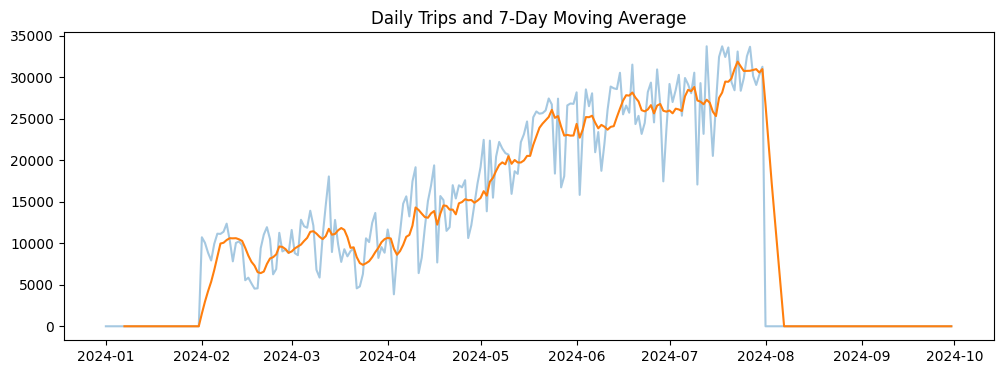

In [14]:
df["trips_7d_ma"] = df["total_trips"].rolling(7).mean()

plt.figure(figsize=(12,4))
plt.plot(df["date"], df["total_trips"], alpha=0.4)
plt.plot(df["date"], df["trips_7d_ma"])
plt.title("Daily Trips and 7-Day Moving Average")
plt.show()


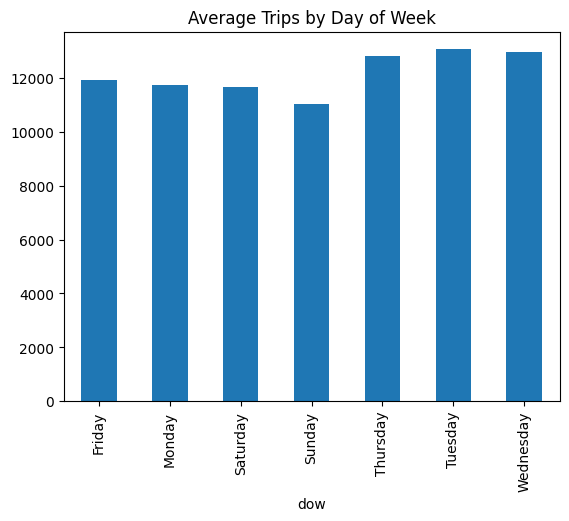

In [15]:
df.groupby("dow")["total_trips"].mean().plot(
    kind="bar", title="Average Trips by Day of Week"
)
plt.show()


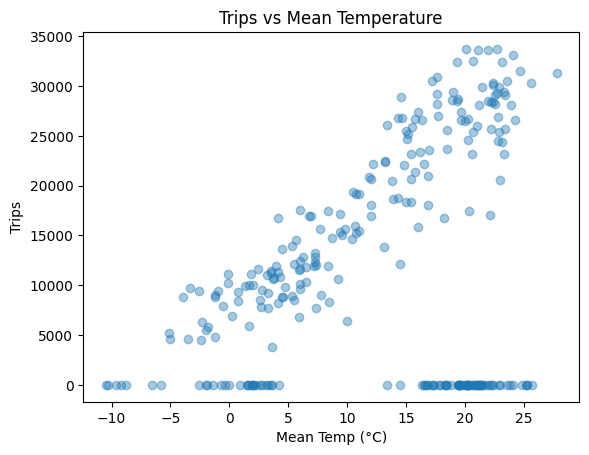

np.float64(0.35654105281438947)

In [16]:
plt.scatter(df["Mean Temp (°C)"], df["total_trips"], alpha=0.4)
plt.xlabel("Mean Temp (°C)")
plt.ylabel("Trips")
plt.title("Trips vs Mean Temperature")
plt.show()

df["Mean Temp (°C)"].corr(df["total_trips"])


In [17]:
# Bike Share Toronto — Demand Forecasting (2024)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("data/processed/powerbi_bike_share_dataset.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")


In [19]:
df["lag_1"] = df["total_trips"].shift(1)
df["lag_7"] = df["total_trips"].shift(7)
df["dow"] = df["date"].dt.day_name()

df = df.dropna()


In [36]:
TEST_DAYS = 28
train = df.iloc[:-TEST_DAYS].copy()
test  = df.iloc[-TEST_DAYS:].copy()

test["pred_baseline"] = test["lag_7"]


In [37]:
test["pred_baseline"] = test["lag_7"]


In [38]:
X_train = train[["lag_1", "lag_7", "Mean Temp (°C)", "Total Precip (mm)", "dow"]]
y_train = train["total_trips"]

X_test  = test[["lag_1", "lag_7", "Mean Temp (°C)", "Total Precip (mm)", "dow"]]
y_test  = test["total_trips"]


In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load
df = pd.read_csv("data/processed/powerbi_bike_share_dataset.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

# Features
df["lag_1"] = df["total_trips"].shift(1)
df["lag_7"] = df["total_trips"].shift(7)
df["dow"] = df["date"].dt.day_name()

# Drop rows where lags are missing
df = df.dropna().copy()

# Train/test split
TEST_DAYS = 28
train = df.iloc[:-TEST_DAYS].copy()
test  = df.iloc[-TEST_DAYS:].copy()

# Baseline prediction (lag-7)
test["pred_baseline"] = test["lag_7"]

# Build X/y
feature_cols = ["lag_1", "lag_7", "Mean Temp (°C)", "Total Precip (mm)", "dow"]
X_train = train[feature_cols]
y_train = train["total_trips"]

X_test  = test[feature_cols]
y_test  = test["total_trips"]

# Regression model
preprocess = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), ["dow"])],
    remainder="passthrough"
)

model = Pipeline([
    ("prep", preprocess),
    ("lr", LinearRegression())
])

model.fit(X_train, y_train)
test["pred_lr"] = model.predict(X_test)

# Metrics
def mae(y, p):
    y = np.array(y); p = np.array(p)
    return np.mean(np.abs(y - p))

def mape(y, p):
    y = np.array(y); p = np.array(p)
    return np.mean(np.abs((y - p) / np.maximum(y, 1))) * 100

print("Baseline MAE:", round(mae(y_test, test["pred_baseline"]), 0))
print("Baseline MAPE:", round(mape(y_test, test["pred_baseline"]), 2), "%")
print("Improved MAE:", round(mae(y_test, test["pred_lr"]), 0))
print("Improved MAPE:", round(mape(y_test, test["pred_lr"]), 2), "%")

# Sanity checks (helps catch the 'MAE=0' issue)
print("\nSanity check:")
print("Actual sample:", test["total_trips"].head(3).tolist())
print("Baseline sample:", test["pred_baseline"].head(3).tolist())
print("Improved sample:", test["pred_lr"].head(3).round(0).tolist())


Baseline MAE: 0.0
Baseline MAPE: 0.0 %
Improved MAE: 1002.0
Improved MAPE: 100169.08 %

Sanity check:
Actual sample: [0, 0, 0]
Baseline sample: [0.0, 0.0, 0.0]
Improved sample: [2511.0, 1278.0, 1111.0]


In [41]:
mae = lambda y, p: abs(y - p).mean()
mape = lambda y, p: (abs(y - p) / y).mean() * 100

print("Baseline MAE:", mae(y_test, test["pred_baseline"]))
print("Baseline MAPE:", mape(y_test, test["pred_baseline"]))

print("Improved MAE:", mae(y_test, test["pred_lr"]))
print("Improved MAPE:", mape(y_test, test["pred_lr"]))


Baseline MAE: 0.0
Baseline MAPE: nan
Improved MAE: 1001.690819176413
Improved MAPE: inf


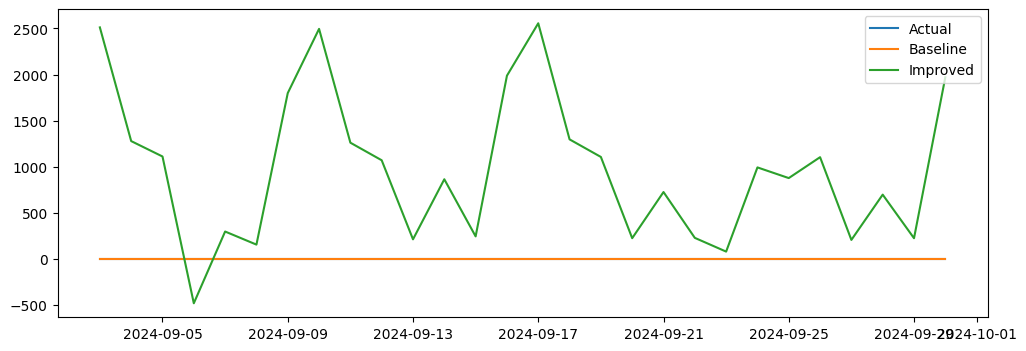

In [42]:
plt.figure(figsize=(12,4))
plt.plot(test["date"], y_test, label="Actual")
plt.plot(test["date"], test["pred_baseline"], label="Baseline")
plt.plot(test["date"], test["pred_lr"], label="Improved")
plt.legend()
plt.show()
